In [1]:
import numpy as np
import uproot
%matplotlib inline
from coffea import hist
#from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
#from coffea.nanoaod import NanoEvents
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np

In [91]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        # Split data into 50 bins, ranging from 0 to 100.
        Muon_axis = hist.Bin("Muon", "Muon [GeV]", 50, 0, 100)
        Electron_axis = hist.Bin("Electron", "Electron [GeV]", 50, 0, 100)
        Loose_muon_axis = hist.Bin("Electron", "Electron [GeV]", 50, 0, 100)
        Test_axis = hist.Bin("Test", "Test [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'Muon': hist.Hist("Counts", dataset_axis, Muon_axis),
            'Electron': hist.Hist("Counts", dataset_axis, Electron_axis),
            'Test': hist.Hist("Counts", dataset_axis, Test_axis)
            #'nMuon': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        # Skim Muon, Electron, and Jet
        Muon = events.Muon
        Muon = Muon[( Muon.pt >10 ) &
                           (np.abs(Muon.eta) < 2.4) &
                           (np.abs(Muon.dxy) < 0.05) &
                           (np.abs(Muon.dz) < 0.1) &
                           (np.abs(Muon.sip3d) < 4) &
                           (Muon.looseId==1) &
                           (Muon.ptErr/Muon.pt < 0.2) &
                           (Muon.mediumId==1) ]
        
        Electron = events.Electron
        Electron = Electron[( Electron.pt >10 ) &  #  (Electron.isTriggerSafeNolso) 
                           (np.abs(Electron.eta+Electron.deltaEtaSC ) < 2.4) &
                            (Electron.convVeto)&
                            (Electron.lostHits==0) &
                            (Electron.tightCharge==2) &
                            (np.abs(Electron.dz) < 0.1) &
                           (np.abs(Electron.dxy) < 0.05) &
                           (np.abs(Electron.sip3d) < 4) ]
        Jet = events.Jet
        Jet = Jet[( Jet.pt >25 ) &  (np.abs(Jet.eta ) < 2.4) ]

        
        def delta_phi(first, second):
            return np.arccos(np.cos(first.phi - second.phi))

        def delta_r2(first, second):
            return (first.eta - second.eta) ** 2 + delta_phi(first, second) ** 2

        def match(first, second, deltaRCut=0.4):
            drCut2 = deltaRCut**2
            combs = ak.cartesian([first, second], nested=True)
            return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)    
        
        def mt(pt1, phi1, pt2, phi2):    #transverse mass
            return np.sqrt( 2*pt1*pt2 * (1 - np.cos(phi1-phi2)) )
        
        # Definition of Tight/Loose Muon and Electron
        Tight_Muon = Muon[( Muon.pt >20 ) &
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.tightId==1) &
                          (Muon.miniPFRelIso_all<0.16)
                         ]
        Tight_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                       #  (Electron.tightId==1) &
                          (Electron.miniPFRelIso_all<0.12)
                         ]
        
        Loose_Muon = Muon[( Muon.pt >20 )&
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.looseId==1) &
                          (Muon.miniPFRelIso_all<0.4)
                         ]        
        
        Loose_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                        # (Electron.looseId==1) &
                          (Electron.miniPFRelIso_all<0.4)
                         ]
        MET = events.MET   
        

        control_region_Muon = events[( ak.num(Loose_Muon)==1) &(ak.num(Loose_Electron)==0)
                                    & (ak.num(Jet[~match(Jet, Muon, deltaRCut=1.0)])>=1) & ( MET.pt<20)]
        #control_region_Muon = control_region_Muon[(mt(Loose_Muon.pt,Loose_Muon.phi, control_region_Muon.MET.pt, control_region_Muon.MET.phi)<20)]
                               
            
        
        
        #binning number of muons/loose and muons/tight based on eta and pt
        #same for electron
        #divide 
        #plot it 
        #tight/loose -> frac
        
        
        
        
        output['Muon'].fill(dataset=dataset, Muon=ak.flatten(Muon.pt))
        output['Electron'].fill(dataset=dataset, Electron=ak.flatten(Electron.pt))
        #output['Muon'].fill(dataset=dataset, Muon=ak.flatten(Muon.pt))
        output['Test'].fill(dataset=dataset, Test=ak.flatten(control_region_Muon.Muon.pt))

   
        return output
        #counts number and the ratio

    def postprocess(self, accumulator):
        return accumulator

In [92]:
#fileset = {'SingleMu' : ["root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root"]}

fileset = {'SingleMu' : ['root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root']}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4,"schema": NanoAODSchema},
                                 chunksize = 250000)


In [38]:
a = output['Electron']

<AxesSubplot:xlabel='Electron [GeV]', ylabel='Counts'>

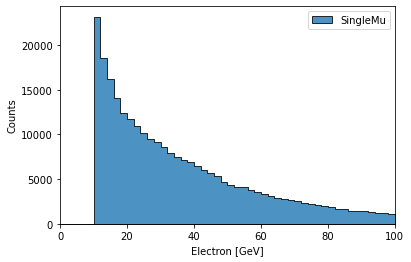

In [39]:
hist.plot1d(a, overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

Debugging

In [ ]:
s = "root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root"

In [41]:
ev = NanoEventsFactory.from_root(s, schemaclass=NanoAODSchema).events()

In [5]:
ev.fields

['HLTriggerFirstPath',
 'SoftActivityJetNjets5',
 'Pileup',
 'SubJet',
 'LHEReweightingWeight',
 'ChsMET',
 'OtherPV',
 'LHEWeight',
 'fixedGridRhoFastjetAll',
 'Tau',
 'CorrT1METJet',
 'L1',
 'LHEScaleWeight',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'PuppiMET',
 'TkMET',
 'SoftActivityJetHT10',
 'LHE',
 'MET',
 'luminosityBlock',
 'PSWeight',
 'SoftActivityJetHT',
 'SoftActivityJetNjets10',
 'PV',
 'IsoTrack',
 'HLT',
 'HLTriggerFinalPath',
 'Photon',
 'event',
 'fixedGridRhoFastjetCentral',
 'CaloMET',
 'SoftActivityJetNjets2',
 'HTXS',
 'genWeight',
 'genTtbarId',
 'L1simulation',
 'SoftActivityJet',
 'Jet',
 'RawMET',
 'fixedGridRhoFastjetCentralNeutral',
 'btagWeight',
 'SubGenJetAK8',
 'Flag',
 'LHEPdfWeight',
 'Electron',
 'SV',
 'FatJet',
 'GenDressedLepton',
 'GenMET',
 'GenPart',
 'Muon',
 'Generator',
 'SoftActivityJetHT2',
 'LHEPart',
 'GenVisTau',
 'L1PreFiringWeight',
 'TrigObj',
 'fixedGridRhoFastjetCentralCalo',
 'run',
 'SoftActivityJetHT5',
 'GenJetAK8',
 'GenJet

In [41]:
ev.Jet.fields

['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepC',
 'btagDeepFlavB',
 'btagDeepFlavC',
 'chEmEF',
 'chFPV0EF',
 'chFPV1EF',
 'chFPV2EF',
 'chFPV3EF',
 'chHEF',
 'eta',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'puId',
 'genJetIdx',
 'hadronFlavour',
 'partonFlavour',
 'cleanmask',
 'electronIdx1G',
 'electronIdx2G',
 'muonIdx1G',
 'muonIdx2G',
 'genJetIdxG',
 'muonIdxG',
 'electronIdxG']

In [2]:
# To change
fileset = {'tHq': ['root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/3A3BA22C-AA71-2544-810A-6DF4C6BA96FC.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/3AFB1F42-BC6D-D44E-86FD-DB93C83F88FF.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/A37B4B7A-FB5B-484D-8577-40B860D77D23.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/E3C7548E-EE40-BA45-9130-17DF56FBE537.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/F9EFC559-09E9-BB48-8150-9AA8B7F02C1C.root'],
            'tHW': ['root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/2806293E-D1DD-4A49-A274-0CC3BA57BBDF.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/2F19962E-1DFB-A14A-91C2-30B69D5651D3.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/D9744111-ED04-3F47-A52A-C18424F01609.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/E4CFA095-E7DB-B449-986D-1A5D21FD1D50.root']}

In [3]:
# the desired sample file seems to be causing issue, using a tutorial file here for comparison
s2 = 'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root'

In [27]:
def delta_phi(first, second):
    return np.arccos(np.cos(first.phi - second.phi))

def delta_r2(first, second):
    return (first.eta - second.eta) ** 2 + delta_phi(first, second) ** 2

def match(first, second, deltaRCut=0.4):
    drCut2 = deltaRCut**2
    combs = ak.cartesian([first, second], nested=True)
    return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)    
a = Jet[~match(Jet, Muon, deltaRCut=1.0)]

def mt(pt1, phi1, pt2, phi2):
    return np.sqrt( 2*pt1*pt2 * (1 - np.cos(phi1-phi2)) )

In [29]:
Muon = ev.Muon
Muon = Muon[( Muon.pt >10 ) &
                           (np.abs(Muon.eta) < 2.4) &
                           (np.abs(Muon.dxy) < 0.05) &
                           (np.abs(Muon.dz) < 0.1) &
                           (np.abs(Muon.sip3d) < 4) &
                           (Muon.looseId==1) &
                           (Muon.ptErr/Muon.pt < 0.2) &
                           (Muon.mediumId==1) ]

In [31]:
Electron = ev.Electron

Electron = Electron[( Electron.pt >10 ) &  #  (Electron.isTriggerSafeNolso) 
                           (np.abs(Electron.eta+Electron.deltaEtaSC ) < 2.4) &
                            (Electron.convVeto)&
                            (Electron.lostHits==0) &
                            (Electron.tightCharge==2) &
                            (np.abs(Electron.dz) < 0.1) &
                           (np.abs(Electron.dxy) < 0.05) &
                           (np.abs(Electron.sip3d) < 4) ]
Jet = ev.Jet
Jet = Jet[( Jet.pt >25 ) &  (np.abs(Jet.eta ) < 2.4) ]
Loose_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                        # (Electron.looseId==1) &
                          (Electron.miniPFRelIso_all<0.4)
                         ]

In [32]:
Loose_Muon = Muon[( Muon.pt >20 )&
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.looseId==1) &
                          (Muon.miniPFRelIso_all<0.4)
                         ]      

In [63]:
MET = ev.MET

In [64]:
Z=mt(Muon.pt,Muon.phi, MET.pt, MET.phi)<20

In [69]:
type(Z)

awkward.highlevel.Array

In [73]:
Z<20

<Array [[True], [], [], ... [], [True], []] type='614400 * var * bool'>

In [77]:
control_region_Muon = ev[(ak.num(Loose_Muon)==1) &(ak.num(Loose_Electron)==0)
                                    & (ak.num(Jet[~match(Jet, Muon, deltaRCut=1.0)])>=1) & ( MET.pt<20)]


In [ ]:
ak.num(Jet[~match(Jet, Muon, deltaRCut=1.0)])>=1

In [ ]:
(mt(control_region_Muon.Muon.pt,control_region_Muon.Muon.phi, control_region_Muon.MET.pt, control_region_Muon.MET.phi)<20

In [78]:
control_region_Muon

<NanoEventsArray [<event 1:351:70065>, ... ] type='11892 * event'>

In [ ]:
 control_region_Muon = events[ak.all( ak.num(Loose_Muon)==1,ak.num(Loose_Electron)==0)]
            
       

In [88]:
A = (mt(Muon.pt,Muon.phi, MET.pt, MET.phi)<20)

In [89]:
B = Loose_Muon

In [90]:
A & B

ValueError: in ListOffsetArray64, cannot broadcast nested list

(https://github.com/scikit-hep/awkward-1.0/blob/1.1.2/src/cpu-kernels/awkward_ListArray_broadcast_tooffsets.cpp#L27)